In [1]:
%load_ext autoreload
%autoreload 2

import anndata as ad
import os
import scipy
import numpy as np
import pandas as pd
import sys
import multivelo as mv
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

sys.path.append("/..")

## Read in the Appropriate Data

Uncomment the top cell to aggragate data for training. Uncomment the bottom cell to aggregate data for validation. (You will need to supply your own AnnData object of validation data.)

In [2]:
# training data

# data used to generate figures in paper
fig3 = sc.read_h5ad("../Examples/multivelo_result_fig3.h5ad")
fig4 = sc.read_h5ad("../Examples/multivelo_result_fig4.h5ad")
fig5 = sc.read_h5ad("../Examples/multivelo_result_fig5.h5ad")
fig6 = sc.read_h5ad("../Examples/multivelo_result_fig6.h5ad")

figs = [fig3, fig4, fig5, fig6]

In [3]:
# vali data
# You will need to supply your own validation data in order to run this code!
# val_data = sc.read_h5ad()
# figs = [val_data]

In [4]:
N = len(figs)

## Define Appropriate Functions

In [5]:
# graph a set of rate parameters
def graph_params(alpha_c, alpha, beta, gamma):

    # the names of the parameters for axis labels
    names = ["alpha_c", "alpha", "beta", "gamma"]

    # create a subplot
    fig, axs = plt.subplots(4, 3, figsize=(12, 12))

    # axis boundaries for each rate parameter
    lims = [0.2, 2, 1.25, 2]

    # assemble the rate parameters into a matrix
    mvln = np.array([alpha_c, alpha, beta, gamma])

    # for each combination of rate parameters...
    for i in range(4):
        col = 0
        for j in range(4):

            # if we're about to plot a rate parameter against
            # itself, then skip this iteration
            if i == j:
                continue

            # graph the rate parameters
            h = axs[i][col].hist2d(np.ravel(mvln[i,:]), np.ravel(mvln[j,:]),
                                   # range=[[0, lims[i]],
                                   #        [0, lims[j]]],
                                   bins=10,
                                   cmap="Greens")
            axs[i][col].set_xlabel(names[i])
            axs[i][col].set_ylabel(names[j])
            fig.colorbar(h[3], ax=axs[i][col])
            col += 1
    
    # # fig.colorbar(axs)
    fig.tight_layout()

In [6]:
# a function for filtering out genes that fall below a certain fit_likelihood threshold
def filter_likelihood(adata, thresh):

    # print out the shape of the AnnData object before filtering
    print("Before shape:", adata.shape)

    # get the fit likelihood of each gene
    fig_likelihood = adata.var['fit_likelihood']

    # draw a histogram of the fit likelihood
    plt.hist(fig_likelihood, bins=40, range=(0, 0.2))

    # do the filtering
    filtered = fig_likelihood > thresh
    return_val = adata[:, filtered]

    # print out the shape of the AnnData object after filtering
    print("After shape:", return_val.shape)
    print()
    
    return return_val

In [7]:
# a function for choosing a subset of the data to use
# like if we wanted to only save enough for a validation set, for example
def subset_data(adata, n=None):

    # if a subset size isn't specified just
    # return the original dataset
    if n is None:
        return adata

    total_genes = adata.shape[1]
    
    full_data = range(total_genes)

    # make a random choice of indices
    choice = np.random.choice(total_genes, size=n, replace=False)

    # subset the AnnData object with our random set
    subset_adata = adata[:,choice]
    
    return subset_adata

In [8]:
# function responsible for saving the relevant data
def write_files(outfile, adatas, graph=False):

        # print the name of the file we're saving to
        print(outfile)

        alpha_c = np.array([])
        alpha = np.array([])
        beta = np.array([])
        gamma = np.array([])

        # assemble the rate parameters of each AnnData object
        for adata in adatas:
        
            alpha_c = np.concatenate((alpha_c, np.array(adata.var['fit_alpha_c'])))
            alpha = np.concatenate((alpha, np.array(adata.var['fit_alpha'])))
            beta = np.concatenate((beta, np.array(adata.var['fit_beta'])))
            gamma = np.concatenate((gamma, np.array(adata.var['fit_gamma'])))

        # graph results if the user specifies it
        if graph:
            graph_results(alpha_c, alpha, beta, gamma)

        # save all of the data
        np.savetxt(outfile + "/alpha_c.txt", alpha_c)
        np.savetxt(outfile + "/alpha.txt", alpha)
        np.savetxt(outfile + "/beta.txt", beta)
        np.savetxt(outfile + "/gamma.txt", gamma)

        # print the total number of genes saved
        print("Number of genes:", alpha_c.shape[0])

## Process and Save Data

Before shape: (3365, 865)
After shape: (3365, 665)

Before shape: (6436, 960)
After shape: (6436, 771)

Before shape: (11605, 936)
After shape: (11605, 655)

Before shape: (4693, 747)
After shape: (4693, 507)

The number of remaining genes is: 26099


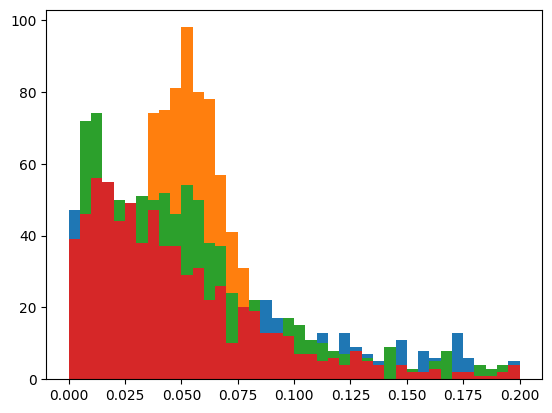

In [9]:
# filter out genes that have a fit likelihood lower
# than this specified value

# used on fig data:
# likelihood_thresh = 0.0

# used on hspc data:
likelihood_thresh = 0.025

# keep a running total of the final number of genes
new_gene_num = 0

# For each AnnData object we're pulling data from,
# filter out the bad data
for i in range(N):
    
    figs[i] = filter_likelihood(figs[i], likelihood_thresh)
    new_gene_num += figs[i].shape[0]

print("The number of remaining genes is:", new_gene_num)

In [10]:
test_figs = []

# Set subset_size to number of genes per
# AnnData object you want if you're generating
# validation data
# subset_size = 30

subset_size = None

# For each AnnData object we're pulling data from,
# pull out a subset:
for i in range(N):
    
    test_fig = subset_data(figs[i],  subset_size)
    test_figs.append(test_fig)

In [11]:
# write the data to the specified file:
# write_files("./data/rates/val_rates", test_figs)
write_files("./data/rates/fig_rates_train", test_figs)

./data/rates/fig_rates_train
Number of genes: 2598
